In [ ]:
# !git clone https://github.com/fizyr/keras-retinanet.git
%cd keras-retinanet

/content/keras-retinanet


In [ ]:
!pip install Pillow
!pip install -r requirements.txt
!pip install . --user
!python setup.py build_ext --inplac
!pip install roboflow

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-3sk85h9b
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-3sk85h9b
Processing /content/keras-retinanet
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=168015 sha256=fda8d63ef0d379c863b5d361d8301a74bab0f229ac6e3f6c17e31791a726b9aa
  Stored in directory: /root/.cache/pip/wheels/32/29/34/9b33c07f08b1be9e77607c1fc6b08c679489aa7ddaed329652
Successfully built keras-retinanet
  Attempting uninstall: keras-retinanet
    Found existing i

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="v40ZMYu9O9KrUmkE9j9O")
project = rf.workspace().project("lpcv_data")
dataset = project.version(4).download("retinanet")
%mkdir inference_models

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to LPCV_data-4 in retinanet:: 100%|██████████| 248/248 [00:00<00:00, 3824.91it/s]


In [ ]:
!keras_retinanet/bin/train.py --steps 100 --weighted-average csv ./LPCV_data-4/train/_annotations.csv ./LPCV_data-4/dataset.txt --val-annotations ./LPCV_data-4/valid/_annotations.csv

102957056/102945312 [==============================] - 2s 0us/step
Creating model, this may take a second...
2021-11-08 07:50:23.222028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 07:50:23.238188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 07:50:23.238784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 07:50:23.239796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 

In [ ]:
!python keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_50.h5 ./inference_models/lpcv_inference50.h5

2021-11-08 08:06:07.010077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 08:06:07.067752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 08:06:07.068360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras_retinanet import models
from keras_retinanet import layers, initializers
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import time
import pathlib
print(tf.version.VERSION)

2.6.0


In [ ]:
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu
from keras.layers import Input
from keras.models import Model

In [ ]:
model =  models.load_model('./inference_models/lpcv_inference50.h5', backbone_name="resnet50")

# Code Below Can be used to run the inference model on an image file or a video

In [ ]:
labels_to_names = {0: 'Person', 1: 'Ball'}

In [ ]:
def detect_image(image, model, class_dict):
  if type(image)==str:
    image = read_image_bgr(image)
  else:
    image = np.ascontiguousarray(Image.fromarray(image).convert('RGB'))
    image = image[:, :, ::-1]
  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)
  # process image
  start = time.time()
  boxes, scores, labels = model.predict(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < 0.5:
          break
          
      color = label_color(label)
      
      b = box.astype(int)
      draw_box(draw, b, color=color)
      
      caption = "{} {:.3f}".format(class_dict[label], score)
      draw_caption(draw, b, caption)
  return draw, time.time() - start

processing time:  0.10963892936706543


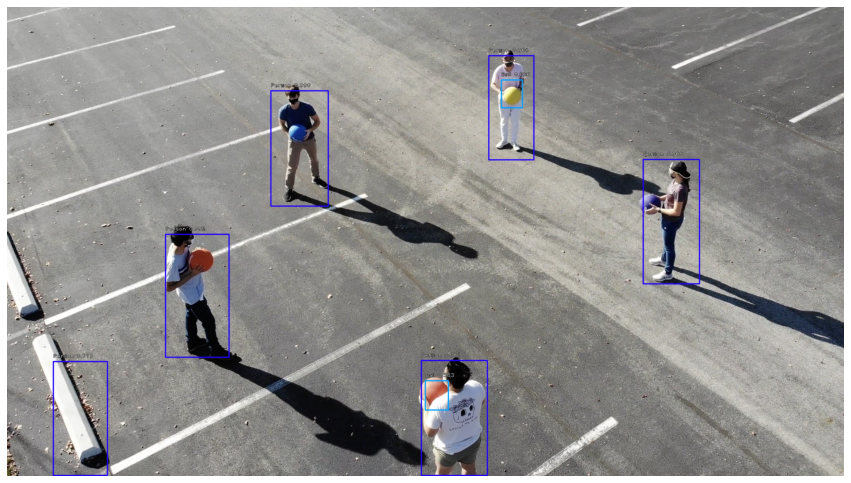

In [ ]:
draw, detect_time = detect_image('test4.jpg', model, labels_to_names)
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [ ]:
def read_video(video, model, class_dict):
  cap = cv2.VideoCapture(video)
  frame_width = int(cap.get(3))
  frame_height = int(cap.get(4))
  frame_size = (frame_width,frame_height)
  fps = 30
  output_file = "TESTOUT"+video
  output = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'XVID'), 30, frame_size)
  count = 0
  times = []
  while(cap.isOpened()):
    print(count)
    count+=1
    ret, frame = cap.read()
    if ret == False:
      break
    draw, time = detect_image(frame, model, class_dict)
    output.write(draw)
    times.append(time)
  cap.release()
  output.release()
  timeave = np.mean(np.array(times))
  print(timeave)

In [ ]:
read_video('5p5b_03A1.mp4', model, labels_to_names)

0
processing time:  0.11147069931030273
1
processing time:  0.11020541191101074
2
processing time:  0.10960507392883301
3
processing time:  0.10852861404418945
4
processing time:  0.11617136001586914
5
processing time:  0.10805821418762207
6
processing time:  0.11375641822814941
7
processing time:  0.10796976089477539
8
processing time:  0.1092979907989502
9
processing time:  0.10912442207336426
10
processing time:  0.10940027236938477
11
processing time:  0.10984063148498535
12
processing time:  0.10836267471313477
13
processing time:  0.11784577369689941
14
processing time:  0.10826635360717773
15
processing time:  0.10955357551574707
16
processing time:  0.1134786605834961
17
processing time:  0.11166119575500488
18
processing time:  0.11562848091125488
19
processing time:  0.11070513725280762
20
processing time:  0.11053729057312012
21
processing time:  0.12177181243896484
22
processing time:  0.1081075668334961
23
processing time:  0.10908365249633789
24
processing time:  0.108266

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cp ./TESTOUT5p5b_03A1.mp4 ../drive/MyDrive/Fall2021/RetinaNet/TESTOUT5p5b03A1.mp4

# Code Below is Meant to Create a tflite file, however it is not working correctly as of now.

In [ ]:
fixed_input = Input((416,416,3))
fixed_model = Model(fixed_input,model(fixed_input))
fixed_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 416, 416, 3)]     0         
_________________________________________________________________
retinanet-bbox (Functional)  [(None, 300, 4), (None, 3 36403702  
Total params: 36,403,702
Trainable params: 36,297,462
Non-trainable params: 106,240
_________________________________________________________________


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/tmp/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"model.tflite"
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmppmewo69w/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


145435844

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(fixed_model)
converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
tflite = converter.convert()
with open("model.tflite","wb") as h:
  h.write(tflite)

INFO:tensorflow:Assets written to: /tmp/tmpchy3i1dd/assets


INFO:tensorflow:Assets written to: /tmp/tmpchy3i1dd/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
def tflite_inference(image, model):
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  print(input_details[0])
  print(output_details[0])
  input_index = input_details[0]["index"]
  output_index = output_details[0]["index"]
  interpreter.allocate_tensors()
  interpreter.set_tensor(input_index, image)
  interpreter.invoke()
  outs = interpreter.get_tensor(output_index)
  return outs
  

In [ ]:
im = preprocess_image((read_image_bgr('test4.jpg')))
np.array(im.resize((416, 416,3)), dtype='float32')
im = np.expand_dims(im, axis=0)
print(im.shape)

(1, 416, 416, 3)


In [ ]:
start = time.time()
outs = tflite_inference(im, tflite_model_file)
end = time.time()-start
print(end)
outs.shape

{'name': 'input_1', 'index': 0, 'shape': array([  1, 416, 416,   3], dtype=int32), 'shape_signature': array([ -1, 416, 416,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'Identity', 'index': 440, 'shape': array([  1, 300,   4], dtype=int32), 'shape_signature': array([ -1, 300,   4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
